# 1. Vision Transformer Architecture

In [7]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from scipy.io import savemat, loadmat
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/ViT architecture/working ViT")
sys.path.append(f"{os.getcwd()}/scripts/")
from VisionTransformer_working import VisionTransformer as Vit_old

sys.path.append(f"{os.getcwd()}/ViT architecture/Architecture tryouts/DPT/")
from VisionTransformer_working_for_DPT import VisionTransformer as Vit

In [8]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [9]:
collect()
torch.cuda.empty_cache()
torch.set_printoptions(precision=6)
device = torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


In [4]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### 1. Comparison of model performances on in-distribution data

#### 1.1 Clean data

Load CNN and ViT model.

In [223]:
vit = Vit(dspl_size=104, 
              patch_size=8, 
              embed_dim=128,
              depth=4,
              n_heads=4,
              mlp_ratio=1.,
              p=0.05,
              attn_p=0.05,
              drop_path=0.).float()
path_to_vit_new = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/logs_and_weights/ViT-clean_2023-Feb-23 16:48:12/ViT-clean_2023-Feb-23 16:48:12.pth'
if torch.cuda.is_available():
    vit.load_state_dict(torch.load(path_to_vit_new)['best_model_weights'], strict=True)
else:
    vit.load_state_dict(torch.load(path_to_vit_new, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

In [237]:
cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/models/model_noise_1e-3.h5')

Load test data.

In [238]:
dspl_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allDisplacements.h5', 'r')['dspl'][1])
trac_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allTractions.h5', 'r')['trac'][1])
#dspl_test = np.concatenate([dspl_test[i] for i in range(dspl_test.shape[0])], axis=0, dtype=np.float32)
#trac_test = np.concatenate([trac_test[i] for i in range(trac_test.shape[0])], axis=0, dtype=np.float32)

In [239]:
sigma = 1e-3
cov = [[sigma ** 2,0],[0, sigma ** 2]]
noise_0 = None
for i, x in tqdm(enumerate(dspl_test), desc='noised'):
    noise = np.random.default_rng().multivariate_normal(mean=[0, 0], cov=cov, size=(104, 104))
    if i == 0:
        noise_0 = noise
    dspl_test[i] = x + noise

noised: 50it [00:00, 1334.85it/s]


In [240]:
X_test = torch.from_numpy(np.moveaxis(dspl_test, 3, 1)).float()
Y_test = torch.from_numpy(np.moveaxis(trac_test, 3, 1)).float()

Export the data to .mat files.

In [8]:
save_files_here = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data/Raw Samples'
xx, yy = np.meshgrid(np.arange(104), np.arange(104), indexing='ij')
pos = np.vstack([xx.reshape(-1), yy.reshape(-1)], dtype=np.double).T
path_to_dir = f'{save_files_here}/Gaussian_noise_1e-04'
os.makedirs(path_to_dir)
for j, sample in enumerate(X_test):
    file_name = f'{path_to_dir}/test_sample_{j + 1}.mat'
    vec_dspl = np.vstack([sample[0].reshape(-1), sample[1].reshape(-1)], dtype=np.double).T
    vec_noise = np.vstack([X_train_noise[j, 0].reshape(-1), X_train_noise[j, 1].reshape(-1)], dtype=np.double).T
    mdict = {'input_data': {'noise': [{'vec': vec_noise, 'pos': pos}, {'vec': vec_noise, 'pos': pos}], 'displacement': [{'vec': vec_dspl, 'pos': pos}, {'vec': vec_dspl, 'pos': pos}]}}
    savemat(file_name, mdict=mdict)

FileExistsError: [Errno 17] File exists: '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data/Raw Samples/Gaussian_noise_1e-04'

Load predictions of the BFFTC method.

In [9]:
bfftc_predictions = torch.zeros((100, 2, 102, 102))
bfftc_displacements = torch.zeros((100, 2, 102, 102))

directory = "/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data/Predictions/Gaussian_noise_1e-04"
    
for j, file in enumerate(os.listdir(f'{directory}')):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"):
        bfft_pred = loadmat(f'{directory}/pred_of_sample_{j + 1}')['TFM_results']['traction'][0][0].T.reshape((2, 102, 102), order='F')
        bfft_dspl = loadmat(f'{directory}/pred_of_sample_{j + 1}')['TFM_results']['displacement'][0][0].T.reshape((2, 102, 102), order='F')
        bfftc_predictions[j] = torch.tensor(bfft_pred)
        bfftc_displacements[j] = torch.tensor(bfft_dspl)

Allocate test samples to ground truths as they got mixed up when BFFTC was performed.

In [287]:
bfftc_predictions_trimmed = torch.zeros((100, 2, 98, 98))
Y_test_trimmed = torch.zeros((100, 3, 98, 98))
X_test_trimmed = torch.zeros((100, 2, 98, 98))

for i, sample in enumerate(bfftc_displacements):
    for j, dspl in enumerate(X_test):
        if torch.allclose(dspl[:, 1:103, 1:103].float(), torch.tensor(sample).float(), atol=1e-02, rtol=1):
            print(f'bfftc dspl {i} matches dspl {j}')
            bfftc_predictions_trimmed[i] = torch.tensor(bfftc_predictions[i, :, 3:101, 3:101]).float()
            Y_test_trimmed[i] = Y_test[j, :, 3:101, 3:101].float()
            X_test_trimmed[i] = dspl[:, 3:101, 3:101].float()

NameError: name 'bfftc_displacements' is not defined

Calculate CNN and ViT prediction on test set.

For test data:

In [241]:
vit.eval()
vit_predictions = vit(X_test)
cnn_predictions = cnn.predict(np.moveaxis(np.array(X_test), 1, 3))

2/2 [==============================] - 1s 102ms/step


In [242]:
mse = torch.nn.MSELoss(reduction='none')
vit_mse = torch.mean(mse(vit_predictions[:, :, 3:101, 3:101], Y_test[:, 0:2, 3:101, 3:101]), (1,2,3))
cnn_mse = torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions, 3, 1)[:, :, 3:101, 3:101]), Y_test[:, 0:2, 3:101, 3:101]), (1,2,3))
#bfftc_mse = torch.mean(mse(bfftc_predictions[:, :, 3:101, 3:101], Y_test[:, 0:2, 3:101, 3:101]), (1,2,3))

In [243]:
vit_mse

tensor([0.001075, 0.001066, 0.001057, 0.001090, 0.001144, 0.001120, 0.001147,
        0.001103, 0.001185, 0.001146, 0.001138, 0.001025, 0.001018, 0.001210,
        0.001043, 0.000980, 0.001024, 0.001222, 0.001093, 0.001050, 0.001140,
        0.001057, 0.001010, 0.001105, 0.001165, 0.000922, 0.001154, 0.001112,
        0.001233, 0.001011, 0.001045, 0.000968, 0.001150, 0.001058, 0.001115,
        0.000940, 0.001177, 0.001235, 0.001304, 0.001102, 0.001125, 0.001132,
        0.001071, 0.001104, 0.001153, 0.001112, 0.001066, 0.001267, 0.001150,
        0.001037], grad_fn=<MeanBackward1>)

In [244]:
cnn_mse

tensor([0.000193, 0.000157, 0.000176, 0.000203, 0.000225, 0.000269, 0.000232,
        0.000234, 0.000327, 0.000348, 0.000220, 0.000193, 0.000224, 0.000258,
        0.000160, 0.000132, 0.000141, 0.000347, 0.000202, 0.000137, 0.000291,
        0.000292, 0.000192, 0.000184, 0.000250, 0.000156, 0.000230, 0.000263,
        0.000252, 0.000209, 0.000202, 0.000155, 0.000310, 0.000263, 0.000202,
        0.000198, 0.000284, 0.000333, 0.000356, 0.000274, 0.000183, 0.000236,
        0.000282, 0.000164, 0.000269, 0.000231, 0.000188, 0.000217, 0.000314,
        0.000149])

In [245]:
torch.mean(vit_mse)

tensor(0.001103, grad_fn=<MeanBackward0>)

In [246]:
torch.mean(cnn_mse)

tensor(0.000230)

Visualize ground truth and predictions for first test sample.

<IPython.core.display.Javascript object>


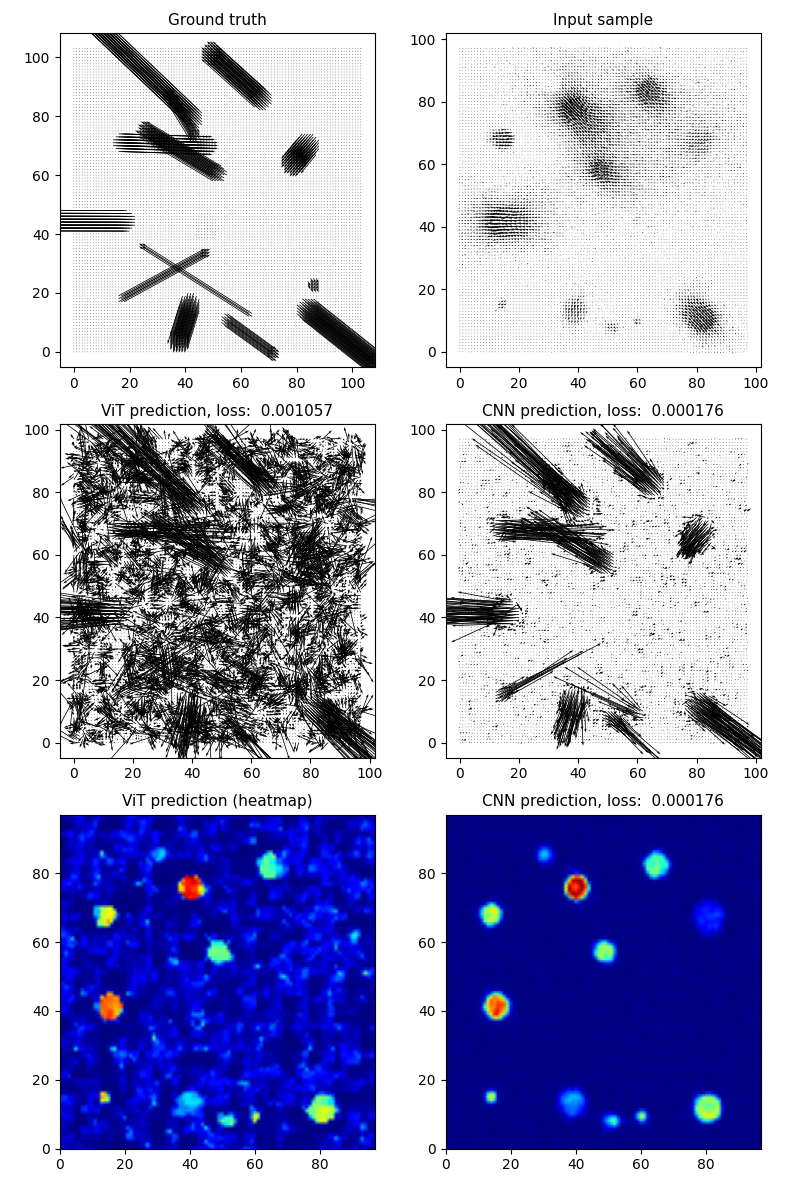

Text(0.5, 1.0, 'CNN prediction, loss:  0.000176')

In [247]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(3, 2, figsize=(8, 12))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(Y_test[2, 0, :, :].detach().numpy(), Y_test[2, 1, :, :].detach().numpy(), scale=1)
axs[0, 0].set_title('Ground truth', {'fontsize': 11})

axs[0, 1].quiver(X_test[2, 0, 3:101, 3:101].detach().numpy(), X_test[2, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[0, 1].set_title(f'Input sample', {'fontsize': 11})

axs[1, 0].quiver(vit_predictions[2, 0, 3:101, 3:101].detach().numpy(), vit_predictions[2, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[1, 0].set_title(f'ViT prediction, loss: {vit_mse[2]:9.6f}', {'fontsize': 11})

axs[1, 1].quiver(cnn_predictions[2, 3:101, 3:101, 0], cnn_predictions[2, 3:101, 3:101, 1], scale=1)
axs[1, 1].set_title(f'CNN prediction, loss: {cnn_mse[2]:9.6f}', {'fontsize': 11})

C = np.sqrt(vit_predictions[2, 0, 3:101, 3:101].detach().numpy() **2 + vit_predictions[2, 1, 3:101, 3:101].detach().numpy() ** 2)
axs[2, 0].pcolormesh(C, cmap='jet', shading='gouraud')
axs[2, 0].set_title('ViT prediction (heatmap)', {'fontsize': 11})

C = np.sqrt(cnn_predictions[2, 3:101, 3:101, 0] **2 + cnn_predictions[2, 3:101, 3:101, 1] ** 2)
im = axs[2, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[2, 1].set_title(f'CNN prediction, loss: {cnn_mse[2]:9.6f}', {'fontsize': 11})

__1.2 Noise level:__ 0.005 * $\langle \sigma_{u}\rangle$

In [10]:
vit = Vit(dspl_size=104, 
              patch_size=8, 
              embed_dim=128,
              depth=4,
              n_heads=4,
              mlp_ratio=1.,
              p=0.05,
              attn_p=0.05,
              drop_path=0.).float()
path_to_vit_new = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/logs_and_weights/ViT-clean_2023-Feb-26 22:41:48/ViT-clean_2023-Feb-26 22:41:48.pth'
if torch.cuda.is_available():
    vit.load_state_dict(torch.load(path_to_vit_new)['best_model_weights'], strict=True)
else:
    vit.load_state_dict(torch.load(path_to_vit_new, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

In [22]:
cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/models/model_noise_1e-4.h5')

In [23]:
dspl_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allDisplacements.h5', 'r')['dspl'][1])
trac_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allTractions.h5', 'r')['trac'][1])
#dspl_test = np.concatenate([dspl_test[i] for i in range(dspl_test.shape[0])], axis=0, dtype=np.float32)
#trac_test = np.concatenate([trac_test[i] for i in range(trac_test.shape[0])], axis=0, dtype=np.float32)

In [24]:
sigma = 0.005 * np.mean(np.var(dspl_test, axis=(1, 2, 3)))
cov = [[sigma ,0],[0, sigma]]
noise_0 = None
for i, x in tqdm(enumerate(dspl_test), desc='noised'):
    noise = np.random.default_rng().multivariate_normal(mean=[0, 0], cov=cov, size=(104, 104))
    if i == 0:
        noise_0 = noise
    dspl_test[i] = x + noise

noised: 50it [00:00, 1913.63it/s]


In [25]:
X_test_noisy = torch.from_numpy(np.moveaxis(dspl_test, 3, 1)).float()
Y_test_noisy = torch.from_numpy(np.moveaxis(trac_test, 3, 1)).float()

In [26]:
vit.eval()
vit_predictions = vit(X_test_noisy)
cnn_predictions = cnn.predict(np.moveaxis(np.array(X_test_noisy), 1, 3))

2/2 [==============================] - 0s 68ms/step


In [27]:
mse = torch.nn.MSELoss(reduction='none')
vit_mse = torch.mean(mse(vit_predictions[:, :, 3:101, 3:101], Y_test_noisy[:, 0:2, 3:101, 3:101]), (1,2,3))
cnn_mse = torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions, 3, 1)[:, :, 3:101, 3:101]), Y_test_noisy[:, 0:2, 3:101, 3:101]), (1,2,3))
#bfftc_mse = torch.mean(mse(bfftc_predictions[:, :, 3:101, 3:101], Y_test[:, 0:2, 3:101, 3:101]), (1,2,3))

In [28]:
vit_mse

tensor([1.081544e-04, 8.029657e-05, 5.569273e-05, 1.078889e-04, 9.802944e-05,
        1.077002e-04, 1.246128e-04, 9.534012e-05, 1.764832e-04, 1.910459e-04,
        1.150896e-04, 7.798552e-05, 6.963866e-05, 9.415829e-05, 4.792840e-05,
        4.360676e-05, 6.112239e-05, 1.735227e-04, 7.249240e-05, 4.544149e-05,
        1.248550e-04, 1.410565e-04, 7.937809e-05, 7.262002e-05, 1.086310e-04,
        6.816217e-05, 9.811415e-05, 1.166400e-04, 1.152519e-04, 6.768916e-05,
        9.632827e-05, 4.723679e-05, 1.325748e-04, 9.767975e-05, 9.240195e-05,
        7.542854e-05, 1.166088e-04, 1.594214e-04, 1.327678e-04, 1.189172e-04,
        6.924789e-05, 8.127437e-05, 1.433896e-04, 6.086070e-05, 1.283877e-04,
        8.661745e-05, 8.849031e-05, 1.002552e-04, 1.269936e-04, 5.663241e-05],
       grad_fn=<MeanBackward1>)

In [29]:
cnn_mse

tensor([0.000598, 0.000626, 0.000552, 0.000606, 0.000531, 0.000675, 0.000690,
        0.000640, 0.000533, 0.000545, 0.000674, 0.000646, 0.000555, 0.000560,
        0.000563, 0.000631, 0.000586, 0.000552, 0.000537, 0.000637, 0.000529,
        0.000662, 0.000530, 0.000631, 0.000544, 0.000684, 0.000630, 0.000547,
        0.000609, 0.000533, 0.000596, 0.000642, 0.000635, 0.000637, 0.000568,
        0.000518, 0.000562, 0.000616, 0.000639, 0.000625, 0.000656, 0.000519,
        0.000583, 0.000596, 0.000616, 0.000639, 0.000495, 0.000616, 0.000614,
        0.000637])

In [30]:
torch.mean(vit_mse)

tensor(9.900285e-05, grad_fn=<MeanBackward0>)

In [31]:
torch.mean(cnn_mse)

tensor(0.000597)

<IPython.core.display.Javascript object>


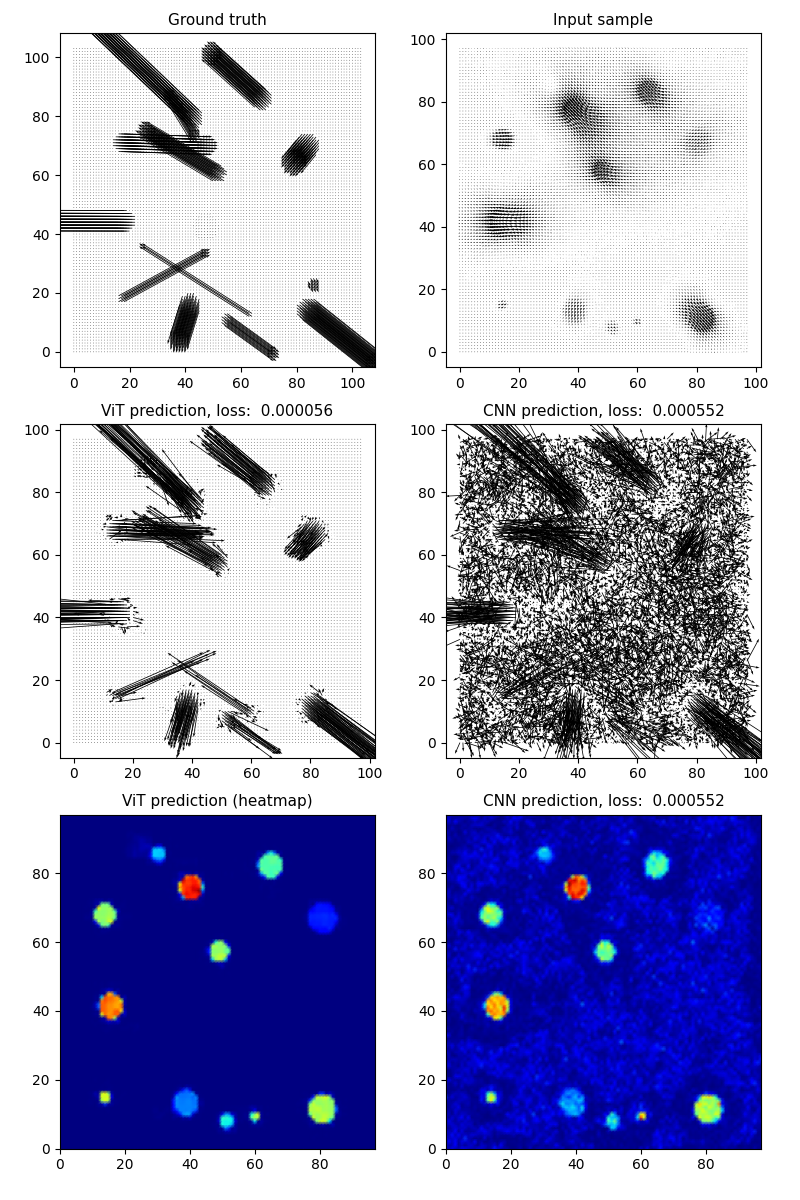

Text(0.5, 1.0, 'CNN prediction, loss:  0.000552')

In [32]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(3, 2, figsize=(8, 12))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(Y_test_noisy[2, 0, :, :].detach().numpy(), Y_test_noisy[2, 1, :, :].detach().numpy(), scale=1)
axs[0, 0].set_title('Ground truth', {'fontsize': 11})

axs[0, 1].quiver(X_test_noisy[2, 0, 3:101, 3:101].detach().numpy(), X_test_noisy[2, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[0, 1].set_title(f'Input sample', {'fontsize': 11})

axs[1, 0].quiver(vit_predictions[2, 0, 3:101, 3:101].detach().numpy(), vit_predictions[2, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[1, 0].set_title(f'ViT prediction, loss: {vit_mse[2]:9.6f}', {'fontsize': 11})

axs[1, 1].quiver(cnn_predictions[2, 3:101, 3:101, 0], cnn_predictions[2, 3:101, 3:101, 1], scale=1)
axs[1, 1].set_title(f'CNN prediction, loss: {cnn_mse[2]:9.6f}', {'fontsize': 11})

C = np.sqrt(vit_predictions[2, 0, 3:101, 3:101].detach().numpy() **2 + vit_predictions[2, 1, 3:101, 3:101].detach().numpy() ** 2)
axs[2, 0].pcolormesh(C, cmap='jet', shading='gouraud')
axs[2, 0].set_title('ViT prediction (heatmap)', {'fontsize': 11})

C = np.sqrt(cnn_predictions[2, 3:101, 3:101, 0] **2 + cnn_predictions[2, 3:101, 3:101, 1] ** 2)
im = axs[2, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[2, 1].set_title(f'CNN prediction, loss: {cnn_mse[2]:9.6f}', {'fontsize': 11})

Compute metrics.

In [16]:
vit_predictions.shape

torch.Size([100, 2, 104, 104])

In [210]:
from MultiTask import append_predictions_and_targets, cosine_sim, adtma, dtma, dma, snr, dtmb

appended_vit_predictions, appended_vit_targets = append_predictions_and_targets(vit_predictions[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], device)
dtma_vit = dtma(appended_vit_predictions, appended_vit_targets, device, True)
dtmb_vit = dtmb(vit_predictions[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
snr_vit = snr(vit_predictions[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
dma_vit = dma(vit_predictions[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
adtma_vit = adtma(appended_vit_predictions, appended_vit_targets, device, True)
cosine_sim_vit = cosine_sim(appended_vit_predictions, appended_vit_targets, device, True)

In [211]:
appended_cnn_predictions, appended_cnn_targets = append_predictions_and_targets(torch.tensor(np.moveaxis(cnn_predictions, 3, 1))[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], device)
dtma_cnn = dtma(appended_cnn_predictions, appended_cnn_targets, device, True)
dtmb_cnn = dtmb(torch.tensor(np.moveaxis(cnn_predictions, 3, 1))[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
snr_cnn = snr(torch.tensor(np.moveaxis(cnn_predictions, 3, 1))[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
dma_cnn = dma(torch.tensor(np.moveaxis(cnn_predictions, 3, 1))[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
adtma_cnn = adtma(appended_cnn_predictions, appended_cnn_targets, device, True)
cosine_sim_cnn = cosine_sim(appended_cnn_predictions, appended_cnn_targets, device, True)

In [212]:
appended_bfftc_predictions, appended_bfftc_targets = append_predictions_and_targets(bfftc_predictions_trimmed, Y_test[:, :, 3:101, 3:101], device)
dtma_bfftc = dtma(appended_bfftc_predictions, appended_bfftc_targets, device, True)
dtmb_bfftc = dtmb(bfftc_predictions_trimmed, Y_test[:, :, 3:101, 3:101], appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
snr_bfftc = snr(bfftc_predictions_trimmed, Y_test[:, :, 3:101, 3:101], appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
dma_bfftc = dma(bfftc_predictions_trimmed, Y_test[:, :, 3:101, 3:101], appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
adtma_bfftc = adtma(appended_bfftc_predictions, appended_bfftc_targets, device, True)
cosine_sim_bfftc = cosine_sim(appended_bfftc_predictions, appended_bfftc_targets, device, True)

In [209]:
'''
dtma_vit = torch.reshape(dtma_vit, (Y_test_trimmed.shape[0], 1))
dtma_cnn = torch.reshape(dtma_cnn, (Y_test_trimmed.shape[0], 1))
dtma_bfftc = torch.reshape(dtma_bfftc, (Y_test_trimmed.shape[0], 1))

cosine_sim_vit = torch.reshape(cosine_sim_vit, (Y_test_trimmed.shape[0], 1))
cosine_sim_cnn = torch.reshape(cosine_sim_cnn, (Y_test_trimmed.shape[0], 1))
cosine_sim_bfftc = torch.reshape(cosine_sim_bfftc, (Y_test_trimmed.shape[0], 1))

dtmb_vit_new = torch.reshape(dtmb_vit, (Y_test_trimmed.shape[0], 1))
dtmb_cnn = torch.reshape(dtmb_cnn, (Y_test_trimmed.shape[0], 1))
dtmb_bfftc = torch.reshape(dtmb_bfftc, (Y_test_trimmed.shape[0], 1))

snr_vit_new = torch.reshape(snr_vit, (Y_test_trimmed.shape[0], 1))
snr_cnn = torch.reshape(snr_cnn, (Y_test_trimmed.shape[0], 1))
snr_bfftc = torch.reshape(snr_bfftc, (Y_test_trimmed.shape[0], 1))

dma_vit_new = torch.reshape(dma_vit, (Y_test_trimmed.shape[0], 1))
dma_cnn = torch.reshape(dma_cnn, (Y_test_trimmed.shape[0], 1))
dma_bfftc = torch.reshape(dma_bfftc, (Y_test_trimmed.shape[0], 1))

adtma_vit_new = torch.reshape(adtma_vit, (Y_test_trimmed.shape[0], 1))
adtma_cnn = torch.reshape(adtma_cnn, (Y_test_trimmed.shape[0], 1))
adtma_bfftc = torch.reshape(adtma_bfftc, (Y_test_trimmed.shape[0], 1))
'''

In [220]:
mses = torch.stack((torch.mean(vit_mse), torch.mean(cnn_mse), torch.mean(bfftc_mse)))
dtmas = torch.stack((torch.mean(dtma_vit), torch.mean(dtma_cnn), torch.mean(dtma_bfftc)))
dtmbs = torch.stack((torch.mean(dtmb_vit), torch.mean(dtmb_cnn), torch.mean(dtmb_bfftc)))
snrs = torch.stack((torch.mean(snr_vit), torch.mean(snr_cnn), torch.mean(snr_bfftc)))
dmas = torch.stack((torch.mean(dma_vit), torch.mean(dma_cnn), torch.mean(dma_bfftc)))
adtmas = torch.stack((torch.mean(adtma_vit), torch.mean(adtma_cnn), torch.mean(adtma_bfftc)))
cos_sims = torch.stack((torch.mean(cosine_sim_vit), torch.mean(cosine_sim_cnn), torch.mean(cosine_sim_bfftc)))

In [253]:
columns = ['MSE', 
           'DTMA', 
           'Cosine sim', 
           'DTMB',
           'SNR',
           'DMA',
           'ADTMA']

metrics = pd.DataFrame(
        np.array(torch.stack((mses, 
                        dtmas,
                        cos_sims,
                        dtmbs, 
                        snrs,
                        dmas,
                        adtmas, 
                       ), 1).detach().numpy()), columns=columns)

float_formatter = "{:.6f}".format

averages = {}
for column in columns:
    averages[column] = f"avg: {float_formatter(round(metrics[column].mean(), ndigits=7))}"
    
averages = pd.DataFrame(averages, index=[0])

In [254]:
def highlight_closes_to_zero(s, props=''):
    return np.where(np.absolute(s) == np.nanmin(np.absolute(s.values)), props, '')

def highlight_max(x, props=''):
    return np.where(x == np.nanmax(x.to_numpy()), props, '')

In [256]:
metrics = metrics.rename(index={0: 'ViT', 1: 'CNN', 2: 'BFFTC'})
slice_ = ['MSE', 'DTMA', 'DTMB', 'DMA', 'ADTMA']
metrics = metrics.style.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=0)
slice_ = ['SNR', 'Cosine sim']
metrics = metrics.apply(highlight_max, props='color:white; background-color:purple', subset=slice_, axis=0)
metrics = metrics.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
metrics.set_properties(**{'text-align': 'center'})

metrics.set_properties(**{"border": "0.5px solid black"})

,MSE,DTMA,Cosine sim,DTMB,SNR,DMA,ADTMA
ViT,0.000060,-0.095683,0.943508,0.004416,49.706181,0.065450,0.096325
CNN,0.000075,-0.205903,0.914052,0.007989,47.141068,-0.075841,0.206614
BFFTC,0.004674,-0.361674,0.094725,0.142906,5.026330,0.306055,0.641559


### 2. Comparison of models on out-of-distribution data

Load CNN and ViT models.

In [33]:
vit = Vit(dspl_size=104, 
              patch_size=8, 
              embed_dim=128,
              depth=4,
              n_heads=4,
              mlp_ratio=1.,
              p=0.05,
              attn_p=0.05,
              drop_path=0.).float()
path_to_vit_new = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/logs_and_weights/ViT-clean_2023-Feb-26 22:41:48/ViT-clean_2023-Feb-26 22:41:48.pth'
if torch.cuda.is_available():
    vit.load_state_dict(torch.load(path_to_vit_new)['best_model_weights'], strict=True)
else:
    vit.load_state_dict(torch.load(path_to_vit_new, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

In [34]:
cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/models/model_noise_1e-4.h5')

Load test set with clean samples.

In [35]:
dspl_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allDisplacements.h5', 'r')['dspl'])
trac_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allTractions.h5', 'r')['trac'])
dspl_test = np.concatenate([dspl_test[i] for i in range(dspl_test.shape[0])], axis=0, dtype=np.float32)
trac_test = np.concatenate([trac_test[i] for i in range(trac_test.shape[0])], axis=0, dtype=np.float32)
#dspl_test = np.moveaxis(dspl_test, 3, 1)
dspl_test = dspl_test[:100]
Y_test = torch.from_numpy(np.moveaxis(trac_test[:100], 3, 1))
#X_test = torch.from_numpy(dspl_test).float()

In [36]:
dspl_test.shape

(100, 104, 104, 2)

Corrupt test set with ten different levels of Gaussian noise.

In [37]:
std_dspl = np.std(dspl_test, axis=(1,2,3))
test_sets = {}
noise_sets = {}
for i in range(1, 11):
    test_set = np.zeros((dspl_test.shape))
    noise_set = np.zeros((dspl_test.shape))
    for j in range(len(dspl_test)):
        sigma = (i/100) * std_dspl[j]
        cov = [[sigma**2,0],[0,sigma**2]]
        noise = np.random.multivariate_normal(np.array([0,0]), cov, (104, 104))
        test_set[j] = dspl_test[j] + noise
        noise_set[j] = noise
    test_sets[f'{i}'] = np.moveaxis(test_set, 3, 1)
    noise_sets[f'{i}'] = np.moveaxis(noise_set, 3, 1)

Visualize test sample with different noise floors.

<IPython.core.display.Javascript object>


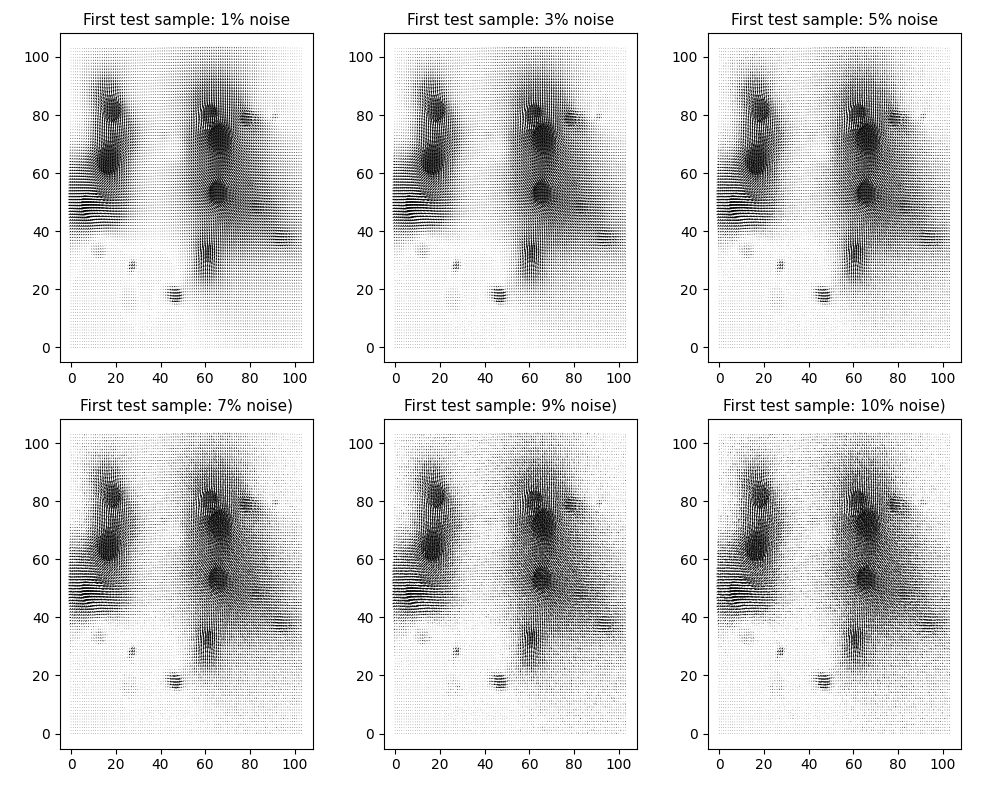

Text(0.5, 1.0, 'First test sample: 10% noise)')

In [38]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(test_sets['1'][0, 0, :, :], test_sets['1'][0, 1, :, :], scale=1)
axs[0, 0].set_title('First test sample: 1% noise', {'fontsize': 11})

axs[0, 1].quiver(test_sets['3'][0, 0, :, :], test_sets['3'][0, 1, :, :], scale=1)
axs[0, 1].set_title('First test sample: 3% noise', {'fontsize': 11})

axs[0, 2].quiver(test_sets['5'][0, 0, :, :], test_sets['5'][0, 1, :, :], scale=1)
axs[0, 2].set_title(f'First test sample: 5% noise', {'fontsize': 11})

axs[1, 0].quiver(test_sets['7'][0, 0, :, :], test_sets['7'][0, 1, :, :], scale=1)
axs[1, 0].set_title(f'First test sample: 7% noise)', {'fontsize': 11})

axs[1, 1].quiver(test_sets['9'][0, 0, :, :], test_sets['9'][0, 1, :, :], scale=1)
axs[1, 1].set_title(f'First test sample: 9% noise)', {'fontsize': 11})

axs[1, 2].quiver(test_sets['10'][0, 0, :, :], test_sets['10'][0, 1, :, :], scale=1)
axs[1, 2].set_title(f'First test sample: 10% noise)', {'fontsize': 11})

In [39]:
print(f'Gaussian noise variance used for training the ViT and CNN: {1.2998083548154682e-07}')

Gaussian noise variance used for training the ViT and CNN: 1.2998083548154682e-07


In [40]:
for i in range(1,11):
    print(f'{i}. Gaussian noise variance for testing the first sample is {((i/100) * std_dspl[0]) ** 2}')

1. Gaussian noise variance for testing the first sample is 8.488191865620166e-09
2. Gaussian noise variance for testing the first sample is 3.3952767462480666e-08
3. Gaussian noise variance for testing the first sample is 7.639372679058147e-08
4. Gaussian noise variance for testing the first sample is 1.3581106984992266e-07
5. Gaussian noise variance for testing the first sample is 2.1220479664050415e-07
6. Gaussian noise variance for testing the first sample is 3.055749071623259e-07
7. Gaussian noise variance for testing the first sample is 4.159214014153882e-07
8. Gaussian noise variance for testing the first sample is 5.432442793996907e-07
9. Gaussian noise variance for testing the first sample is 6.875435411152334e-07
10. Gaussian noise variance for testing the first sample is 8.488191865620166e-07


Predictions by ViT and CNN for test sample.

In [41]:
vit.eval()
vit_predictions = {}
cnn_predictions = {}
for num, test_set in test_sets.items():
    vit_predictions[num] = vit(torch.tensor(test_set).float())
    cnn_predictions[num] = cnn.predict(np.moveaxis(np.array(test_set), 1, 3))

4/4 [==============================] - 0s 39ms/step


In [42]:
vit_mse = {}
cnn_mse = {}
noise_levels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
mse = torch.nn.MSELoss(reduction='none')
for noise_level in noise_levels:
    vit_mse[noise_level] = torch.mean(mse(vit_predictions[noise_level][:, :, 3:101, 3:101], Y_test[:, 0:2, 3:101, 3:101]))
    cnn_mse[noise_level] = torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions[noise_level], 3, 1)[:, :, 3:101, 3:101]), Y_test[:, 0:2, 3:101, 3:101]))

In [43]:
vit_mse

{'1': tensor(9.223134e-05, grad_fn=<MeanBackward0>),
 '2': tensor(9.278184e-05, grad_fn=<MeanBackward0>),
 '3': tensor(9.361876e-05, grad_fn=<MeanBackward0>),
 '4': tensor(9.477331e-05, grad_fn=<MeanBackward0>),
 '5': tensor(9.605064e-05, grad_fn=<MeanBackward0>),
 '6': tensor(9.778509e-05, grad_fn=<MeanBackward0>),
 '7': tensor(0.000101, grad_fn=<MeanBackward0>),
 '8': tensor(0.000105, grad_fn=<MeanBackward0>),
 '9': tensor(0.000112, grad_fn=<MeanBackward0>),
 '10': tensor(0.000119, grad_fn=<MeanBackward0>)}

In [44]:
cnn_mse

{'1': tensor(8.389966e-05),
 '2': tensor(9.052567e-05),
 '3': tensor(0.000106),
 '4': tensor(0.000151),
 '5': tensor(0.000252),
 '6': tensor(0.000420),
 '7': tensor(0.000651),
 '8': tensor(0.000939),
 '9': tensor(0.001293),
 '10': tensor(0.001716)}

<IPython.core.display.Javascript object>


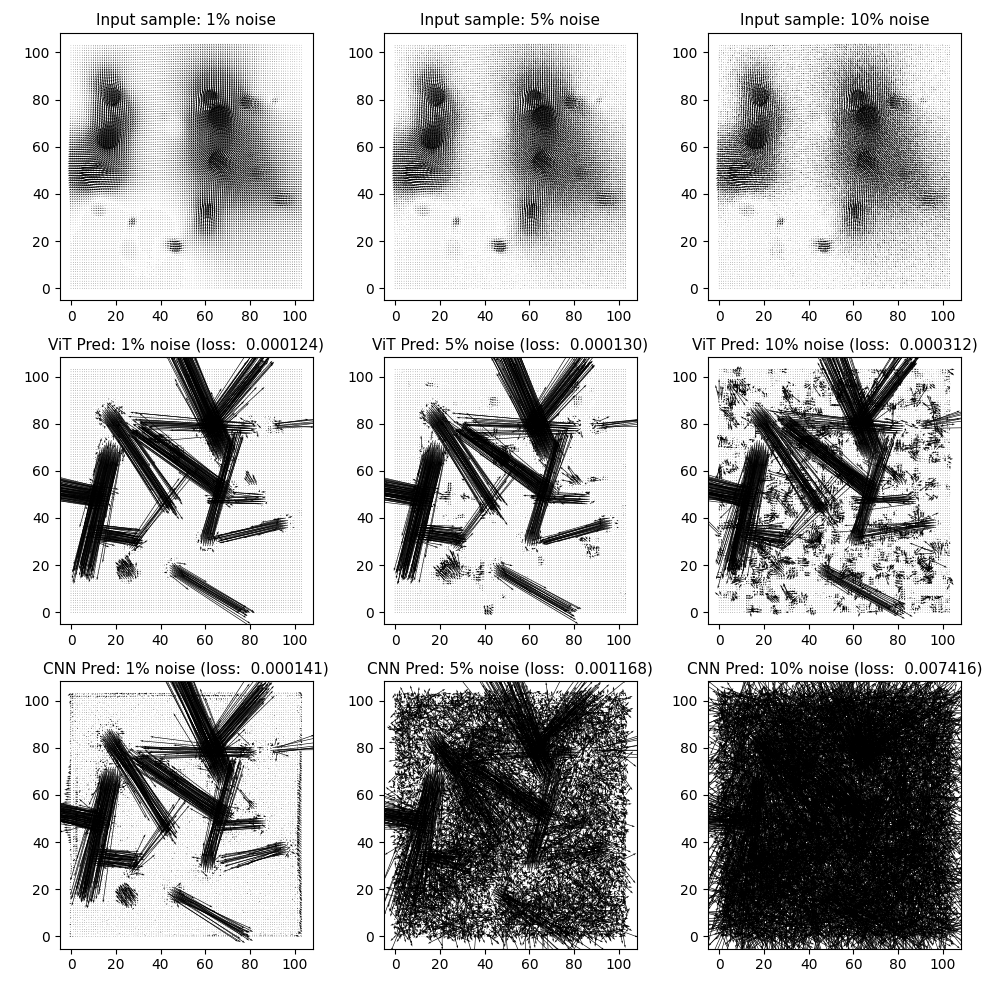

Text(0.5, 1.0, 'CNN Pred: 10% noise (loss:  0.007416)')

In [45]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(test_sets['1'][0, 0, :, :], test_sets['1'][0, 1, :, :], scale=1)
axs[0, 0].set_title(f'Input sample: 1% noise', {'fontsize': 11})

axs[0, 1].quiver(test_sets['5'][0, 0, :, :], test_sets['5'][0, 1, :, :], scale=1)
axs[0, 1].set_title(f'Input sample: 5% noise', {'fontsize': 11})

axs[0, 2].quiver(test_sets['10'][0, 0, :, :], test_sets['10'][0, 1, :, :], scale=1)
axs[0, 2].set_title(f'Input sample: 10% noise', {'fontsize': 11})

axs[1, 0].quiver(vit_predictions['1'][0, 0, :, :].detach().numpy(), vit_predictions['1'][0, 1, :, :].detach().numpy(), scale=1)
axs[1, 0].set_title(f'ViT Pred: 1% noise (loss: {torch.mean(mse(vit_predictions["1"][0].unsqueeze(dim=0), Y_test[0, 0:2].unsqueeze(dim=0))):9.6f})', {'fontsize': 11})

axs[1, 1].quiver(vit_predictions['5'][0, 0, :, :].detach().numpy(), vit_predictions['5'][0, 1, :, :].detach().numpy(), scale=1)
axs[1, 1].set_title(f'ViT Pred: 5% noise (loss: {torch.mean(mse(vit_predictions["5"][0].unsqueeze(dim=0), Y_test[0, 0:2].unsqueeze(dim=0))):9.6f})', {'fontsize': 11})

axs[1, 2].quiver(vit_predictions['10'][0, 0, :, :].detach().numpy(), vit_predictions['10'][0, 1, :, :].detach().numpy(), scale=1)
axs[1, 2].set_title(f'ViT Pred: 10% noise (loss: {torch.mean(mse(vit_predictions["10"][0].unsqueeze(dim=0), Y_test[0, 0:2].unsqueeze(dim=0))):9.6f})', {'fontsize': 11})

axs[2, 0].quiver(cnn_predictions['1'][0, :, :, 0], cnn_predictions['1'][0, :, :, 1], scale=1)
axs[2, 0].set_title(f'CNN Pred: 1% noise (loss: {torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions["1"], 3, 1)[0, :, 3:101, 3:101]), Y_test[0, 0:2, 3:101, 3:101])):9.6f})', {'fontsize': 11})

axs[2, 1].quiver(cnn_predictions['5'][0, :, :, 0], cnn_predictions['5'][0, :, :, 1], scale=1)
axs[2, 1].set_title(f'CNN Pred: 5% noise (loss: {torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions["5"], 3, 1)[0, :, 3:101, 3:101]), Y_test[0, 0:2, 3:101, 3:101])):9.6f})', {'fontsize': 11})

axs[2, 2].quiver(cnn_predictions['10'][0, :, :, 0], cnn_predictions['10'][0, :, :, 1], scale=1)
axs[2, 2].set_title(f'CNN Pred: 10% noise (loss: {torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions["10"], 3, 1)[0, :, 3:101, 3:101]), Y_test[0, 0:2, 3:101, 3:101])):9.6f})', {'fontsize': 11})

Export test sets to mat files.

In [ ]:
save_files_here = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data/Raw Samples'
xx, yy = np.meshgrid(np.arange(104), np.arange(104), indexing='ij')
pos = np.vstack([xx.reshape(-1), yy.reshape(-1)], dtype=np.double).T
for i in range(1, 11):
    path_to_dir = f'{save_files_here}/{i}'
    os.makedirs(path_to_dir)
    for j, sample in enumerate(test_sets[f'{i}']):
        file_name = f'{path_to_dir}/test_sample_{j + 1}.mat'
        vec_dspl = np.vstack([sample[0].reshape(-1), sample[1].reshape(-1)], dtype=np.double).T
        vec_noise = np.vstack([noise_sets[f'{i}'][j, 0].reshape(-1), noise_sets[f'{i}'][j, 1].reshape(-1)], dtype=np.double).T
        mdict = {'input_data': {'noise': [{'vec': vec_noise, 'pos': pos}, {'vec': vec_noise, 'pos': pos}], 'displacement': [{'vec': vec_dspl, 'pos': pos}, {'vec': vec_dspl, 'pos': pos}]}}
        savemat(file_name, mdict=mdict)

Load BFFTC predictions for each test set.

In [ ]:
bfftc_prediction_sets = {}
bfftc_displacement_sets = {}

directory = "/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data/Predictions"
    
for i, _ in enumerate(os.listdir(directory), 1):
    bfftc_prediction = np.zeros((Y_test.shape[0], 2, 102, 102))
    bfftc_displacement = np.zeros((Y_test.shape[0], 2, 102, 102))
    for j, file in enumerate(os.listdir(f'{directory}/{i}')):
        filename = os.fsdecode(file)
        if filename.endswith(".mat"):
            bfft_pred = loadmat(f'{directory}/{i}/{filename}')['TFM_results']['traction'][0][0].T.reshape((2, 102, 102), order='F')
            bfft_dspl = loadmat(f'{directory}/{i}/{filename}')['TFM_results']['displacement'][0][0].T.reshape((2, 102, 102), order='F')
            bfftc_prediction[j] = bfft_pred
            bfftc_displacement[j] = bfft_dspl
    bfftc_prediction_sets[f'{i}'] = bfftc_prediction
    bfftc_displacement_sets[f'{i}'] = bfftc_displacement

Find correct samples in test set and remove outer rims.

In [ ]:
'''
def allcocate_and_trim(bfftc_prediction_sets, num_processes):
    bfftc_prediction_sets_trimmed = {}
    ground_truth_sets_trimmed = {}
    noisy_X_test_sets_trimmed = {}
    pool = mp.Pool(processes=num_processes)
    for num, pred in bfftc_prediction_sets.items():
        pool.apply_async(one_alloc, args=(num, pred))
    pool.close()
    pool.join()
    
def one_alloc(num, pred):
    bfftc_prediction_set_trimmed = torch.zeros((test_sets[num].shape[0], test_sets[num].shape[1], 98, 98))
    ground_truths_trimmed = torch.zeros((test_sets[num].shape[0], 3, 98, 98))
    X_test_noisy = torch.zeros(test_sets[num].shape)
    for i, sample in tqdm(enumerate(bfftc_displacement_sets[num])):
        for j, dspl in enumerate(torch.tensor(test_sets[num])):
            if torch.allclose(dspl[:, 1:103, 1:103].float(), torch.tensor(sample).float(), atol=1e-02, rtol=1):
                # print(f'Set {num}: sample {i} matches with dspl {j}')
                bfftc_prediction_set_trimmed[i] = torch.tensor(bfftc_prediction_sets[num][i, :, 3:101, 3:101]).float()
                ground_truths_trimmed[i] = Y_test[j, :, 3:101, 3:101].float()
                X_test_noisy[i] = dspl.float()
    bfftc_prediction_sets_trimmed[num] = bfftc_prediction_set_trimmed
    ground_truth_sets_trimmed[num] = ground_truths_trimmed
    noisy_X_test_sets_trimmed[num] = X_test_noisy 
    
'''

In [ ]:
bfftc_prediction_sets_trimmed = {}
ground_truth_sets_trimmed = {}
noisy_X_test_sets_trimmed = {}

for num, pred in tqdm(bfftc_prediction_sets.items()):
    bfftc_prediction_set_trimmed = torch.zeros((test_sets[num].shape[0], test_sets[num].shape[1], 98, 98))
    ground_truths_trimmed = torch.zeros((test_sets[num].shape[0], 3, 98, 98))
    X_test_noisy = torch.zeros(test_sets[num].shape)
    for i, sample in enumerate(bfftc_displacement_sets[num]):
        for j, dspl in enumerate(torch.tensor(test_sets[num])):
            if torch.allclose(dspl[:, 1:103, 1:103].float(), torch.tensor(sample).float(), atol=1e-02, rtol=1):
                # print(f'Set {num}: sample {i} matches with dspl {j}')
                bfftc_prediction_set_trimmed[i] = torch.tensor(bfftc_prediction_sets[num][i, :, 3:101, 3:101]).float()
                ground_truths_trimmed[i] = Y_test[j, :, 3:101, 3:101].float()
                X_test_noisy[i] = dspl.float()
    bfftc_prediction_sets_trimmed[num] = bfftc_prediction_set_trimmed
    ground_truth_sets_trimmed[num] = ground_truths_trimmed
    noisy_X_test_sets_trimmed[num] = X_test_noisy

Sanity check.

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(noisy_X_test_sets_trimmed['1'][0, 0, :, :].detach().numpy(), noisy_X_test_sets_trimmed['1'][0, 1, :, :].detach().numpy(), scale=1)
axs[0, 0].set_title(f'First test sample: 1% noise', {'fontsize': 11})

axs[0, 1].quiver(noisy_X_test_sets_trimmed['5'][0, 0, :, :].detach().numpy(), noisy_X_test_sets_trimmed['5'][0, 1, :, :].detach().numpy(), scale=1)
axs[0, 1].set_title(f'First test sample: 5% noise', {'fontsize': 11})

axs[0, 2].quiver(noisy_X_test_sets_trimmed['10'][0, 0, :, :].detach().numpy(), noisy_X_test_sets_trimmed['10'][0, 1, :, :].detach().numpy(), scale=1)
axs[0, 2].set_title(f'First test sample: 10% noise', {'fontsize': 11})

axs[1, 0].quiver(ground_truth_sets_trimmed['1'][0, 0, :, :].detach().numpy(), ground_truth_sets_trimmed['1'][0, 1, :, :].detach().numpy(), scale=1)
axs[1, 0].set_title(f'CNN Pred: 1% noise (loss: {cnn_mse["1"][0]:9.6f})', {'fontsize': 11})

axs[1, 1].quiver(ground_truth_sets_trimmed['5'][0, 0, :, :].detach().numpy(), ground_truth_sets_trimmed['5'][0, 1, :, :], scale=1)
axs[1, 1].set_title(f'CNN Pred: 5% noise (loss: {cnn_mse["5"][0]:9.6f})', {'fontsize': 11})

axs[1, 2].quiver(ground_truth_sets_trimmed['10'][0, 0, :, :].detach().numpy(), ground_truth_sets_trimmed['10'][0, 1, :, :], scale=1)
axs[1, 2].set_title(f'CNN Pred: 10% noise (loss: {cnn_mse["10"][0]:9.6f})', {'fontsize': 11})

In [ ]:
'''
bfftc_predictions_trimmed = torch.zeros((X_test_noisy.shape[0], X_test_noisy.shape[1], 98, 98))
ground_truths_trimmed = torch.zeros((Y_test.shape[0], Y_test.shape[1], 98, 98))
X_test_noisy_ = torch.zeros(X_test_noisy.shape)

for i, sample in enumerate(bfftc_displacements):
    for j, dspl in enumerate(X_test_noisy):
        if torch.allclose(dspl[:, 1:103, 1:103].float(), torch.tensor(sample).float(), atol=1e-02, rtol=1):
            print(f'sample {i} matches with dspl {j}')
            bfftc_predictions_trimmed[i] = torch.tensor(bfftc_predictions[i, :, 3:101, 3:101]).float()
            ground_truths_trimmed[i] = Y_test[j, :, 3:101, 3:101].float()
            X_test_noisy_[i] = dspl.float()
'''

In [ ]:
vit_new.eval()
vit_predictions = {}
cnn_predictions = {}
for num, test_set in test_sets.items():
    vit_predictions[num] = vit_new(torch.tensor(test_set).float(), device=device)
    cnn_predictions[num] = cnn.predict(np.moveaxis(np.array(test_set), 1, 3))

In [ ]:
vit_metrics = {}
cnn_metrics = {}
bfftc_metrics = {}

In [ ]:
def compute_mse_for_noise_levels(vit_predictions, cnn_predictions, bfftc_prediction_sets_trimmed, ground_truth_sets_trimmed, noisy_X_test_sets_trimmed):
    vit_mse = {}
    cnn_mse = {}
    #bfftc_mse = {}
    noise_levels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    mse = torch.nn.MSELoss(reduction='none')
    for noise_level in noise_levels:
        vit_mse[noise_level] = torch.mean(torch.mean(mse(vit_predictions[noise_level][:, :, 3:101, 3:101], Y_test[:, 0:2, 3:101, 3:101]), (1,2,3)))
        cnn_mse[noise_level] = torch.mean(torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions[noise_level], 3, 1)[:, :, 3:101, 3:101]), Y_test[:, 0:2, 3:101, 3:101]), (1,2,3)))
        #bfftc_mse[noise_level] = torch.mean(torch.mean(mse(bfftc_prediction_sets_trimmed[noise_level], ground_truth_sets_trimmed[noise_level][:, 0:2]), (1,2,3)))
    
    return vit_mse, cnn_mse

In [ ]:
vit_metrics['mse'], cnn_metrics['mse'] = compute_mse_for_noise_levels(vit_predictions, cnn_predictions, bfftc_prediction_sets_trimmed, ground_truth_sets_trimmed, noisy_X_test_sets_trimmed)

In [ ]:
lists = vit_metrics['mse'].items() # sorted by key, return a list of tuples
x, y_vit = zip(*lists) # unpack a list of pairs into two tuples
x = sorted([int(i) for i in x])
y_vit = [i.item() for i in y_vit]
lists = cnn_metrics['mse'].items() # sorted by key, return a list of tuples
_, y_cnn = zip(*lists) # unpack a list of pairs into two tuples
y_cnn = [i.item() for i in y_cnn]

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, y_vit, 'o-', color='green', label='Vit')
plt.plot(x, y_cnn, 'o-', color='blue', label='CNN')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('MSE', )

In [ ]:
from MultiTask import append_predictions_and_targets, cosine_sim, adtma, dtma, dma, snr, dtmb

appended_vit_predictions = {}
appended_vit_targets = {}
appended_cnn_predictions = {}
appended_cnn_targets = {}
appended_bfftc_predictions = {}
appended_bfftc_targets = {}

noise_levels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
for noise_level in noise_levels:
    appended_vit_predictions[noise_level], appended_vit_targets[noise_level] = append_predictions_and_targets(vit_predictions[noise_level][:, :, 3:101, 3:101], ground_truth_sets_trimmed[noise_level], device)

In [ ]:
for noise_level in noise_levels:
    appended_cnn_predictions[noise_level], appended_cnn_targets[noise_level] = append_predictions_and_targets(torch.tensor(np.moveaxis(cnn_predictions[noise_level], 3, 1))[:, :, 3:101, 3:101], ground_truth_sets_trimmed[noise_level], device)

In [ ]:
'''
for noise_level in noise_levels:
    appended_bfftc_predictions[noise_level], appended_bfftc_targets[noise_level] = append_predictions_and_targets(bfftc_prediction_sets_trimmed[noise_level], ground_truth_sets_trimmed[noise_level], device)
'''

In [ ]:
def compute_dtma_for_noise_levels(appended_vit_predictions, appended_vit_targets, appended_cnn_predictions, appended_cnn_targets, appended_bfftc_predictions, appended_bfftc_targets):
    vit_dtma = {}
    cnn_dtma = {}
    #bfftc_dtma = {}
    noise_levels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    for noise_level in tqdm(noise_levels):
        vit_dtma[noise_level] = dtma(appended_vit_predictions[noise_level], appended_vit_targets[noise_level], device, False)
        cnn_dtma[noise_level] =  dtma(appended_cnn_predictions[noise_level], appended_cnn_targets[noise_level], device, False)
        #bfftc_dtma[noise_level] =  dtma(appended_bfftc_predictions[noise_level], appended_bfftc_targets[noise_level], device, False)
    
    return vit_dtma, cnn_dtma

In [ ]:
vit_metrics['dtma'], cnn_metrics['dtma'] = compute_dtma_for_noise_levels(appended_vit_predictions, appended_vit_targets, appended_cnn_predictions, appended_cnn_targets, appended_bfftc_predictions, appended_bfftc_targets)

In [ ]:
lists = vit_metrics['dtma'].items() # sorted by key, return a list of tuples
x1, y_vit = zip(*lists) # unpack a list of pairs into two tuples

In [ ]:
x1 = sorted([int(i) for i in x1])
y_vit = [i.item() for i in y_vit]
lists = cnn_metrics['dtma'].items() # sorted by key, return a list of tuples
x2, y_cnn = zip(*lists) # unpack a list of pairs into two tuples
y_cnn = [i.item() for i in y_cnn]
x2 = sorted([int(i) for i in x2])

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x1, y_vit, 'o-', color='green', label='Vit')
plt.plot(x2, y_cnn, 'o-', color='blue', label='CNN')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('DTMA')

<IPython.core.display.Javascript object>


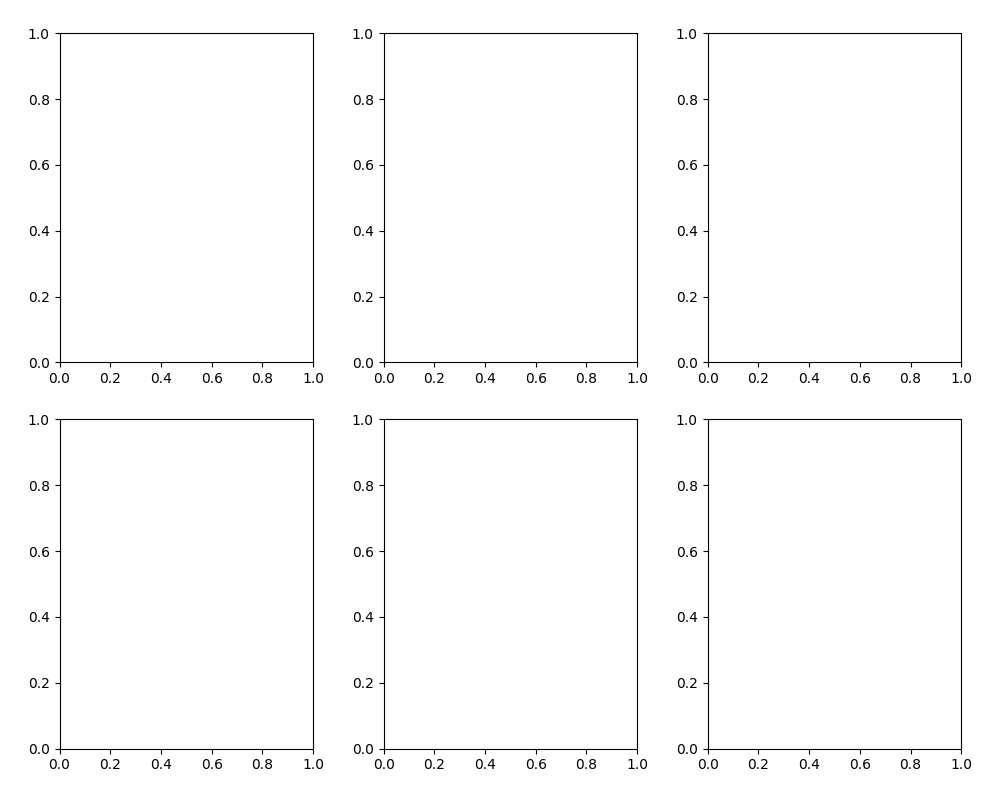

TypeError: new(): invalid data type 'str'

In [264]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(vit_predictions['1'][0, 0, :, :].detach().numpy(), vit_predictions['1'][0, 1, :, :].detach().numpy(), scale=1)
axs[0, 0].set_title('Vit prediction: low noise', {'fontsize': 11})

axs[0, 1].quiver(vit_predictions['5'][0, 0, :, :].detach().numpy(), vit_predictions['5'][0, 1, :, :].detach().numpy(), scale=1)
axs[0, 1].set_title('Vit prediction: medium noise', {'fontsize': 11})

axs[0, 2].quiver(vit_predictions['10'][0, 0, :, :].detach().numpy(), vit_predictions['10'][0, 1, :, :].detach().numpy(), scale=1)
axs[0, 2].set_title(f'Vit prediction: high noise', {'fontsize': 11})

axs[1, 0].quiver(cnn_predictions['1'][0, :, :, 0], cnn_predictions['1'][0, :, :, 1], scale=1)
axs[1, 0].set_title(f'CNN prediction: low noise)', {'fontsize': 11})

axs[1, 1].quiver(cnn_predictions['5'][0, :, :, 0], cnn_predictions['5'][0, :, :, 1], scale=1)
axs[1, 1].set_title(f'CNN prediction: medium noise)', {'fontsize': 11})

axs[1, 2].quiver(cnn_predictions['10'][0, :, :, 0], cnn_predictions['10'][0, :, :, 1], scale=1)
axs[1, 2].set_title(f'CNN prediction: high noise)', {'fontsize': 11})

In [ ]:
def compute_dtmb_for_noise_levels(appended_vit_predictions, appended_vit_targets, appended_cnn_predictions, appended_cnn_targets, appended_bfftc_predictions, appended_bfftc_targets):
    vit_dtmb = {}
    cnn_dtmb = {}
    # bfftc_dtmb = {}
    noise_levels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    for noise_level in tqdm(noise_levels):
        vit_dtmb[noise_level] = dtmb(vit_predictions[noise_level][:, :, 3:101, 3:101], ground_truth_sets_trimmed[noise_level], appended_vit_predictions[noise_level], appended_vit_targets[noise_level], device, False)
        cnn_dtmb[noise_level] =  dtmb(torch.tensor(np.moveaxis(cnn_predictions[noise_level], 3, 1))[:, :, 3:101, 3:101], ground_truth_sets_trimmed[noise_level], appended_cnn_predictions[noise_level], appended_cnn_targets[noise_level], device, False)
        # bfftc_dtmb[noise_level] =  dtmb(appended_bfftc_predictions[noise_level], appended_bfftc_targets[noise_level], device, False)
    
    return vit_dtmb, cnn_dtmb

In [ ]:
vit_metrics['dtmb'], cnn_metrics['dtmb'] = compute_dtmb_for_noise_levels(appended_vit_predictions, appended_vit_targets, appended_cnn_predictions, appended_cnn_targets, appended_bfftc_predictions, appended_bfftc_targets)

In [ ]:
vit_metrics

In [ ]:
lists = vit_metrics['dtmb'].items() # sorted by key, return a list of tuples
x, y_vit = zip(*lists) # unpack a list of pairs into two tuples
x = sorted([int(i) for i in x])
y_vit = [i.item() for i in y_vit]
lists = cnn_metrics['dtmb'].items() # sorted by key, return a list of tuples
_, y_cnn = zip(*lists) # unpack a list of pairs into two tuples
y_cnn = [i.item() for i in y_cnn]

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, y_vit, 'o-', color='green', label='Vit')
plt.plot(x, y_cnn, 'o-', color='blue', label='CNN')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('DTMB')

In [ ]:
def compute_snr_for_noise_levels(appended_vit_predictions, appended_vit_targets, appended_cnn_predictions, appended_cnn_targets, appended_bfftc_predictions, appended_bfftc_targets):
    vit_snr = {}
    cnn_snr = {}
    # bfftc_snr = {}
    noise_levels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    for noise_level in tqdm(noise_levels):
        vit_snr[noise_level] = snr(vit_predictions[noise_level][:, :, 3:101, 3:101], ground_truth_sets_trimmed[noise_level], appended_vit_predictions[noise_level], appended_vit_targets[noise_level], device, False)
        cnn_snr[noise_level] =  snr(torch.tensor(np.moveaxis(cnn_predictions[noise_level], 3, 1))[:, :, 3:101, 3:101], ground_truth_sets_trimmed[noise_level], appended_cnn_predictions[noise_level], appended_cnn_targets[noise_level], device, False)
        # bfftc_snr[noise_level] =  snr(appended_bfftc_predictions[noise_level], appended_bfftc_targets[noise_level], device, False)
    
    return vit_snr, cnn_snr

In [ ]:
vit_metrics['snr'], cnn_metrics['snr'] = compute_snr_for_noise_levels(appended_vit_predictions, appended_vit_targets, appended_cnn_predictions, appended_cnn_targets, appended_bfftc_predictions, appended_bfftc_targets)

In [ ]:
lists = vit_metrics['snr'].items() # sorted by key, return a list of tuples
x, y_vit = zip(*lists) # unpack a list of pairs into two tuples
x = sorted([int(i) for i in x])
y_vit = [i.item() for i in y_vit]
lists = cnn_metrics['snr'].items() # sorted by key, return a list of tuples
_, y_cnn = zip(*lists) # unpack a list of pairs into two tuples
y_cnn = [i.item() for i in y_cnn]

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, y_vit, 'o-', color='green', label='Vit')
plt.plot(x, y_cnn, 'o-', color='blue', label='CNN')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('SNR')

In [ ]:
lists = vit_metrics['dma'].items() # sorted by key, return a list of tuples
x, y_vit = zip(*lists) # unpack a list of pairs into two tuples
x = sorted([int(i) for i in x])
y_vit = [i.item() for i in y_vit]
lists = cnn_metrics['dma'].items() # sorted by key, return a list of tuples
_, y_cnn = zip(*lists) # unpack a list of pairs into two tuples
y_cnn = [i.item() for i in y_cnn]

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, y_vit, 'o-', color='green', label='Vit')
plt.plot(x, y_cnn, 'o-', color='blue', label='CNN')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('DMA')

In [ ]:
def compute_dma_for_noise_levels(appended_vit_predictions, appended_vit_targets, appended_cnn_predictions, appended_cnn_targets, appended_bfftc_predictions, appended_bfftc_targets):
    vit_dma = {}
    cnn_dma = {}
    # bfftc_dma = {}
    noise_levels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    for noise_level in tqdm(noise_levels):
        vit_dma[noise_level] = dma(vit_predictions[noise_level][:, :, 3:101, 3:101], ground_truth_sets_trimmed[noise_level], appended_vit_predictions[noise_level], appended_vit_targets[noise_level], device, False)
        cnn_dma[noise_level] =  dma(torch.tensor(np.moveaxis(cnn_predictions[noise_level], 3, 1))[:, :, 3:101, 3:101], ground_truth_sets_trimmed[noise_level], appended_cnn_predictions[noise_level], appended_cnn_targets[noise_level], device, False)
        # bfftc_dma[noise_level] =  dma(appended_bfftc_predictions[noise_level], appended_bfftc_targets[noise_level], device, False)
    
    return vit_dma, cnn_dma

In [ ]:
def compute_adtma_for_noise_levels(appended_vit_predictions, appended_vit_targets, appended_cnn_predictions, appended_cnn_targets, appended_bfftc_predictions, appended_bfftc_targets):
    vit_adtma = {}
    cnn_adtma = {}
    bfftc_adtma = {}
    noise_levels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    for noise_level in tqdm(noise_levels):
        vit_adtma[noise_level] = adtma(appended_vit_predictions[noise_level], appended_vit_targets[noise_level], device, False)
        cnn_adtma[noise_level] = adtma(appended_cnn_predictions[noise_level], appended_cnn_targets[noise_level], device, False)
        bfftc_adtma[noise_level] = adtma(appended_bfftc_predictions[noise_level], appended_bfftc_targets[noise_level], device, False)
    
    return vit_adtma, cnn_adtma, bfftc_adtma

In [ ]:
vit_metrics['adtma'], cnn_metrics['adtma'], bfftc_metrics['adtma'] = compute_adtma_for_noise_levels(appended_vit_predictions, appended_vit_targets, appended_cnn_predictions, appended_cnn_targets, appended_bfftc_predictions, appended_bfftc_targets)

In [ ]:
def compute_cosine_sim_for_noise_levels(appended_vit_predictions, appended_vit_targets, appended_cnn_predictions, appended_cnn_targets, appended_bfftc_predictions, appended_bfftc_targets):
    vit_cos_sim = {}
    cnn_cos_sim = {}
    # bfftc_cos_sim = {}
    noise_levels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    for noise_level in tqdm(noise_levels):
        vit_cos_sim[noise_level] = cosine_sim(appended_vit_predictions[noise_level], appended_vit_targets[noise_level], device, False)
        cnn_cos_sim[noise_level] =  cosine_sim(appended_cnn_predictions[noise_level], appended_cnn_targets[noise_level], device, False)
        #bfftc_cos_sim[noise_level] =  cosine_sim(appended_bfftc_predictions[noise_level], appended_bfftc_targets[noise_level], device, False)
    
    return vit_cos_sim, cnn_cos_sim

In [ ]:
vit_metrics['cos_sim'], cnn_metrics['cos_sim']= compute_cosine_sim_for_noise_levels(appended_vit_predictions, appended_vit_targets, appended_cnn_predictions, appended_cnn_targets, appended_bfftc_predictions, appended_bfftc_targets)

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 8, figsize=(10, 8))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(X_test_noisy_[0, 0, :, :].detach().numpy(), X_test_noisy_[0, 1, :, :].detach().numpy(), scale=1)
axs[0, 0].set_title('Test sample: displacement', {'fontsize': 11})

axs[0, 1].quiver(ground_truths_trimmed[0, 0, :, :].detach().numpy(), ground_truths_trimmed[0, 1, :, :].detach().numpy(), scale=2)
axs[0, 1].set_title('Test sample: traction', {'fontsize': 11})

axs[0, 2].quiver(X_test_noise[0, 0, :, :], X_test_noise[0, 1, :, :], scale=0.05)
axs[0, 2].set_title(f'Test sample: Gaussian noise floor', {'fontsize': 11})

axs[1, 0].quiver(pred_vit_new[0, 0, :, :].detach().numpy(), pred_vit_new[0, 1, :, :].detach().numpy(), scale=1)
axs[1, 0].set_title(f'ViT pred (loss:{mse_vit_new[0, 0]:9.6f})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0, :, :, 0], pred_cnn[0, :, :, 1], scale=1)
axs[1, 1].set_title(f'CNN pred (loss:{mse_cnn[0, 0]:9.6f})', {'fontsize': 11})

axs[1, 2].quiver(bfftc_predictions_trimmed[0, 0, :, :], bfftc_predictions_trimmed[0, 1, :, :], scale=1)
axs[1, 2].set_title(f'BFFTC pred (loss:{mse_bfftc[0, 0]:9.6f})', {'fontsize': 11})

Compute MSE, DTMA and DDA for the predictions.

In [ ]:
vit_new.eval()
pred_vit_new = vit_new(X_test_noisy, device=device)
pred_cnn = cnn.predict(np.moveaxis(np.array(X_test_noisy), 1, 3))

In [ ]:
from MultiTask import append_predictions_and_targets, cosine_sim, adtma, dtma, dma, snr, dtmb

mse = torch.nn.MSELoss(reduction='none')
mse_vit_new = torch.mean(mse(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed[:, 0:2]), (1, 2, 3))
mse_cnn = torch.mean(mse(torch.tensor(np.moveaxis(pred_cnn, 3, 1)[:, :, 3:101, 3:101]), ground_truths_trimmed[:, 0:2]), (1, 2, 3))
mse_bfftc = torch.mean(mse(bfftc_predictions_trimmed, ground_truths_trimmed[:, 0:2]), (1, 2, 3))

mse_vit_new = torch.reshape(mse_vit_new, (ground_truths_trimmed.shape[0], 1))
mse_cnn = torch.reshape(mse_cnn, (ground_truths_trimmed.shape[0], 1))
mse_bfftc = torch.reshape(mse_bfftc, (ground_truths_trimmed.shape[0], 1))

In [ ]:
appended_vit_predictions, appended_vit_targets = append_predictions_and_targets(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed, device)
dtma_vit_new = dtma(appended_vit_predictions, appended_vit_targets, device, True)
dtmb_vit_new = dtmb(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed, appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
snr_vit_new = snr(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed, appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
dma_vit_new = dma(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed, appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
adtma_vit_new = adtma(appended_vit_predictions, appended_vit_targets, device, True)

In [ ]:
cosine_sim_vit_new = cosine_sim(appended_vit_predictions, appended_vit_targets, device, True)

In [ ]:
appended_cnn_predictions, appended_cnn_targets = append_predictions_and_targets(torch.tensor(np.moveaxis(pred_cnn, 3, 1))[:, :, 3:101, 3:101], ground_truths_trimmed, device)
dtma_cnn = dtma(appended_cnn_predictions, appended_cnn_targets, device, True)
dtmb_cnn = dtmb(torch.tensor(np.moveaxis(pred_cnn, 3, 1))[:, :, 3:101, 3:101], ground_truths_trimmed, appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
snr_cnn = snr(torch.tensor(np.moveaxis(pred_cnn, 3, 1))[:, :, 3:101, 3:101], ground_truths_trimmed, appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
dma_cnn = dma(torch.tensor(np.moveaxis(pred_cnn, 3, 1))[:, :, 3:101, 3:101], ground_truths_trimmed, appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
adtma_cnn = adtma(appended_cnn_predictions, appended_cnn_targets, device, True)

In [ ]:
cosine_cnn = cosine_sim(appended_cnn_predictions, appended_cnn_targets, device, True)

In [ ]:
appended_bfftc_predictions, appended_bfftc_targets = append_predictions_and_targets(bfftc_predictions_trimmed, ground_truths_trimmed, device)
dtma_bfftc = dtma(appended_bfftc_predictions, appended_bfftc_targets, device, True)
dda_bfftc = dda(appended_bfftc_predictions, appended_bfftc_targets, device, True)
dtmb_bfftc = dtmb(bfftc_predictions_trimmed, ground_truths_trimmed, appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
snr_bfftc = snr(bfftc_predictions_trimmed, ground_truths_trimmed, appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
dma_bfftc = dma(bfftc_predictions_trimmed, ground_truths_trimmed, appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
adtma_bfftc = adtma(appended_bfftc_predictions, appended_bfftc_targets, device, True)

In [ ]:
cosine_bfftc = cosine_sim(appended_bfftc_predictions, appended_bfftc_targets, device, True)

In [ ]:
dtma_vit_new = torch.reshape(dtma_vit_new, (ground_truths_trimmed.shape[0], 1))
dtma_cnn = torch.reshape(dtma_cnn, (ground_truths_trimmed.shape[0], 1))
dtma_bfftc = torch.reshape(dtma_bfftc, (ground_truths_trimmed.shape[0], 1))

cosine_sim_vit_new = torch.reshape(cosine_sim_vit_new, (ground_truths_trimmed.shape[0], 1))
cosine_cnn = torch.reshape(cosine_cnn, (ground_truths_trimmed.shape[0], 1))
cosine_bfftc = torch.reshape(cosine_bfftc, (ground_truths_trimmed.shape[0], 1))

dtmb_vit_new = torch.reshape(dtmb_vit_new, (ground_truths_trimmed.shape[0], 1))
dtmb_cnn = torch.reshape(dtmb_cnn, (ground_truths_trimmed.shape[0], 1))
dtmb_bfftc = torch.reshape(dtmb_bfftc, (ground_truths_trimmed.shape[0], 1))

snr_vit_new = torch.reshape(snr_vit_new, (ground_truths_trimmed.shape[0], 1))
snr_cnn = torch.reshape(snr_cnn, (ground_truths_trimmed.shape[0], 1))
snr_bfftc = torch.reshape(snr_bfftc, (ground_truths_trimmed.shape[0], 1))

dma_vit_new = torch.reshape(dma_vit_new, (ground_truths_trimmed.shape[0], 1))
dma_cnn = torch.reshape(dma_cnn, (ground_truths_trimmed.shape[0], 1))
dma_bfftc = torch.reshape(dma_bfftc, (ground_truths_trimmed.shape[0], 1))

adtma_vit_new = torch.reshape(adtma_vit_new, (ground_truths_trimmed.shape[0], 1))
adtma_cnn = torch.reshape(adtma_cnn, (ground_truths_trimmed.shape[0], 1))
adtma_bfftc = torch.reshape(adtma_bfftc, (ground_truths_trimmed.shape[0], 1))

In [ ]:
def highlight_closes_to_zero(s, props=''):
    return np.where(np.absolute(s) == np.nanmin(np.absolute(s.values)), props, '')

In [ ]:
def highlight_max(x, props=''):
    return np.where(x == np.nanmax(x.to_numpy()), props, '')

In [ ]:
columns = ['MSE ViT', 
           'MSE CNN',
           'MSE BFFTC',
           'DTMA ViT', 
           'DTMA CNN',
           'DTMA BFFTC',
           'Cosine sim ViT', 
           'Cosine sim CNN',
           'Cosine sim BFFTC',
           'DTMB ViT',
           'DTMB CNN',
           'DTMB BFFTC',
           'SNR ViT',
           'SNR CNN',
           'SNR BFFTC',
           'DMA ViT',
           'DMA CNN',
           'DMA BFFTC',
           'ADTMA ViT',
           'ADTMA CNN',
           'ADTMA BFFTC']

metrics = pd.DataFrame(
    np.array(torch.cat((mse_vit_new, 
                        mse_cnn,
                        mse_bfftc,
                        dtma_vit_new, 
                        dtma_cnn,
                        dtma_bfftc,
                        cosine_sim_vit_new, 
                        cosine_cnn,
                        cosine_bfftc,
                        dtmb_vit_new,
                        dtmb_cnn,
                        dtmb_bfftc,
                        snr_vit_new,
                        snr_cnn,
                        snr_bfftc,
                        dma_vit_new,
                        dma_cnn,
                        dma_bfftc,
                        adtma_vit_new,
                        adtma_cnn,
                        adtma_bfftc
                       ), 1).detach().numpy()), columns=columns)

float_formatter = "{:.6f}".format

averages = {}
for column in columns:
    averages[column] = f"avg: {float_formatter(round(metrics[column].mean(), ndigits=7))}"
    
averages = pd.DataFrame(averages, index=[0])

In [ ]:
metrics
metrics.index += 1 
metrics.loc['mean'] = metrics.mean()
metrics = metrics.tail(32)
slice_ = ['MSE ViT', 'MSE CNN', 'MSE BFFTC']
metrics = metrics.style.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['DTMA ViT', 'DTMA CNN', 'DTMA BFFTC']
metrics = metrics.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['Cosine sim ViT', 'Cosine sim CNN','Cosine sim BFFTC']
metrics = metrics.apply(highlight_max, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['DTMB ViT', 'DTMB CNN','DTMB BFFTC']
metrics = metrics.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['SNR ViT', 'SNR CNN', 'SNR BFFTC']
metrics = metrics.apply(highlight_max, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['DMA ViT', 'DMA CNN', 'DMA BFFTC']
metrics = metrics.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['ADTMA ViT', 'ADTMA CNN', 'ADTMA BFFTC']
metrics = metrics.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
metrics = metrics.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
metrics.set_properties(**{'text-align': 'center'})

metrics.set_properties(**{"border": "0.5px solid black"})

Plot example cell.

In [ ]:
torch.set_printoptions(sci_mode=False)
torch.set_printoptions(precision=5)

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(X_test_noisy_[0, 0, :, :].detach().numpy(), X_test_noisy_[0, 1, :, :].detach().numpy(), scale=1)
axs[0, 0].set_title('Test sample: displacement', {'fontsize': 11})

axs[0, 1].quiver(ground_truths_trimmed[0, 0, :, :].detach().numpy(), ground_truths_trimmed[0, 1, :, :].detach().numpy(), scale=2)
axs[0, 1].set_title('Test sample: traction', {'fontsize': 11})

axs[0, 2].quiver(X_test_noise[0, 0, :, :], X_test_noise[0, 1, :, :], scale=0.05)
axs[0, 2].set_title(f'Test sample: Gaussian noise floor', {'fontsize': 11})

axs[1, 0].quiver(pred_vit_new[0, 0, :, :].detach().numpy(), pred_vit_new[0, 1, :, :].detach().numpy(), scale=1)
axs[1, 0].set_title(f'ViT pred (loss:{mse_vit_new[0, 0]:9.6f})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0, :, :, 0], pred_cnn[0, :, :, 1], scale=1)
axs[1, 1].set_title(f'CNN pred (loss:{mse_cnn[0, 0]:9.6f})', {'fontsize': 11})

axs[1, 2].quiver(bfftc_predictions_trimmed[0, 0, :, :], bfftc_predictions_trimmed[0, 1, :, :], scale=1)
axs[1, 2].set_title(f'BFFTC pred (loss:{mse_bfftc[0, 0]:9.6f})', {'fontsize': 11})

Implementation of DTMB

In [ ]:
Y_test.shape

In [ ]:
appended_multi_targets[0, 2, :, :, :]

Visualize the first test sample, its ground truth and the models' predictions.

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(bfftc_displacements[0, 0, :, :], bfftc_displacements[0, 1, :, :], scale=1)
axs[0, 0].set_title('Displacement field returned by etutfm', {'fontsize': 11})

axs[0, 1].quiver(X_test_noisy[0, 0, :, :].detach().numpy(), X_test_noisy[0, 1, :, :].detach().numpy(), scale=1)
axs[0, 1].set_title(f'Displacement field of X_test_noisy', {'fontsize': 11})

axs[1, 0].quiver(bfftc_predictions_trimmed[0, 0, :, :], bfftc_predictions_trimmed[0, 1, :, :], scale=50)
axs[1, 0].set_title(f'TFM prediction (loss: None)', {'fontsize': 11})

axs[1, 1].quiver(pred_vit_new[0, 0, :, :].detach().numpy(), pred_vit_new[0, 1, :, :].detach().numpy(), scale=1)
axs[1, 1].set_title(f'ViT prediction (loss: {torch.round(mse_vit_new[0, 0], decimals=5)})', {'fontsize': 11})

ym = 0,1 kPa

In [ ]:
path_to_sample_1 = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Bay-FTTC_results_01-02-23.mat'

In [ ]:
bfft_pred = loadmat(path_to_sample_1)['TFM_results']['traction'][0][0].T.reshape((2, 102, 102), order='F')
bfft_dspl = loadmat(path_to_sample_1)['TFM_results']['displacement'][0][0].T.reshape((2, 102, 102), order='F')

In [ ]:
bfft_pred.shape

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(bfft_pred[0, :, :], bfft_pred[1, :, :], scale=0.01)
axs[0].set_title('bfft_pred', {'fontsize': 11})

axs[1].quiver(bfft_dspl[0, :, :], bfft_dspl[1, :, :], scale=1)
axs[1].set_title(f'bfft_dspl', {'fontsize': 11})

ym = 0,01 kPa

In [ ]:
path_to_sample_1 = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Bay-FTTC_results_01-02-23.mat'
bfft_pred = loadmat(path_to_sample_1)['TFM_results']['traction'][0][0].T.reshape((2, 102, 102), order='F')
bfft_dspl = loadmat(path_to_sample_1)['TFM_results']['displacement'][0][0].T.reshape((2, 102, 102), order='F')

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(bfft_pred[0, :, :], bfft_pred[1, :, :], scale=1)
axs[0].set_title('bfft_pred', {'fontsize': 11})

axs[1].quiver(bfft_dspl[0, :, :], bfft_dspl[1, :, :], scale=1)
axs[1].set_title(f'bfft_dspl', {'fontsize': 11})

### Visualization of attention maps

In [ ]:
def compute_attention_map(attn_scores):
    """
    Compute the attention rollout tensors for each layer in a ViT architecture. We assume a batch size of 1.
    
    Parameters
    __________
    attn_scores : List
        List of raw attention tensors for each encoder block.
        
    Returns
    _______
    joint_attentions : List
        List of attention rollouts for each layer.
    
    grid_size : int
        Number of patches per dimension of original (quadratic) input.
    """
    # Stack raw attention tensors in a matrix, get rid of singleton (batch) dimension and average over all attention heads per layer.
    attn_mat = torch.stack(attn_scores) # (depth, n_samples, n_heads, n_patches, n_patches)
    attn_mat = attn_mat.squeeze(1) # (depth, n_heads, n_patches, n_patches)
    attn_mat = torch.mean(attn_mat, dim=1) # (depth, n_heads, n_patches, n_patches)
    
    # Account for skip connections in the architecture
    residual_attn = torch.eye(attn_mat.size(1))
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / aug_attn_mat.sum(dim=-1).unsqueeze(-1)
    
    # Recursively compute attention rollouts 
    joint_attentions = torch.zeros(aug_attn_mat.size())
    joint_attentions[0] = aug_attn_mat[0].double()
    for n in range(1, aug_attn_mat.size(0)):
        joint_attentions[n] = aug_attn_mat[n].double() @ joint_attentions[n-1].double()
    
    grid_size = int(np.sqrt(aug_attn_mat.size(-1)))
    
    return joint_attentions, grid_size

We extract the attention weights of each encoder block for the first test sample and compute the attention rollouts.

In [ ]:
_, attn_scores = vit((X_test[0, :, :, :][np.newaxis, ...]), return_attention=True)
joint_attentions, grid_size = compute_attention_map(attn_scores)

Visualize the test sample and select one patch. We will then track the attention rollout of this patch among the network.

In [ ]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test[0, 0, :, :], X_test[0 ,1 ,: , :], scale=1)
axs[0].set_title('Input as strain map', {'fontsize': 11})

C = np.sqrt(X_test[0, 0, :, :] **2 + X_test[0, 1, :, :] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input as heatmap', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 3 and column == 8:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(8*8, 3*8), width=8, height=8, linewidth=2, color='red', fill=False))

Plot rolled out attention map of chosen patch at each layer of the encoder.

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][47, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 8})
        ind += 1

Next, another test sample with a more "cell-like" geometry is analysed.

In [ ]:
os.chdir('..')
sys.path.append(f"{os.getcwd()}/DL_TFM/scripts/")
from data_preparation import matFiles_to_npArray

In [ ]:
X_test_ = matFiles_to_npArray('comparables/generic')[1]
Y_test_ = matFiles_to_npArray('comparables/generic')[0]
X_test_ = np.moveaxis(np.array(X_test_['dspl'])[np.newaxis, ...], 3, 1)
Y_test_ = np.moveaxis(np.array(Y_test_['trac'])[np.newaxis, ...], 3, 1)

In [ ]:
_, attn_scores = vit(torch.tensor(X_test_).double(), True)
joint_attentions, grid_size = compute_attention_map(attn_scores)

In [ ]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test_[0,0,:,:], X_test_[0,1,:,:], scale=20)
axs[0].set_title('Input (strain vectors)', {'fontsize': 11})

C = np.sqrt(X_test_[0,0,:,:] **2 + X_test_[0,1,:,:] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input (heatmap)', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 7 and column == 9:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(9*8, 7*8), width=8, height=8, linewidth=1, color='red', fill=False))

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][100, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test_[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 10})
        ind += 1